<a href="https://colab.research.google.com/github/mandar3319/Image_Classification/blob/main/image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
# !git clone https://github.com/mandar3319/Image_Classification.git

Cloning into 'Image_Classification'...
fatal: could not read Username for 'https://github.com': No such device or address


In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  89.0M      0  0:00:08  0:00:08 --:--:-- 63.8M


In [3]:
!unzip -q kagglecatsanddogs_5340.zip
!ls

 CDLA-Permissive-2.0.pdf   kagglecatsanddogs_5340.zip   PetImages  'readme[1].txt'   sample_data


In [4]:
!ls PetImages

Cat  Dog


In [5]:
import os
num_skipped=0
for folder_name in ("Cat","Dog"):
    folder_path=os.path.join("PetImages",folder_name)
    for fname in os.listdir(folder_path):

        fpath=os.path.join(folder_path,fname)
        try:
            fobj=open(fpath,"rb")
            is_jfif=tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()
        if not is_jfif:
            num_skipped += 1
            os.remove(fpath)
    print("Deleted %d images" % num_skipped)

Deleted 759 images
Deleted 1590 images


In [6]:
image_size=(180,180)
batch_size=128
train_ds,val_ds=tf.keras.utils.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 4682 files for validation.


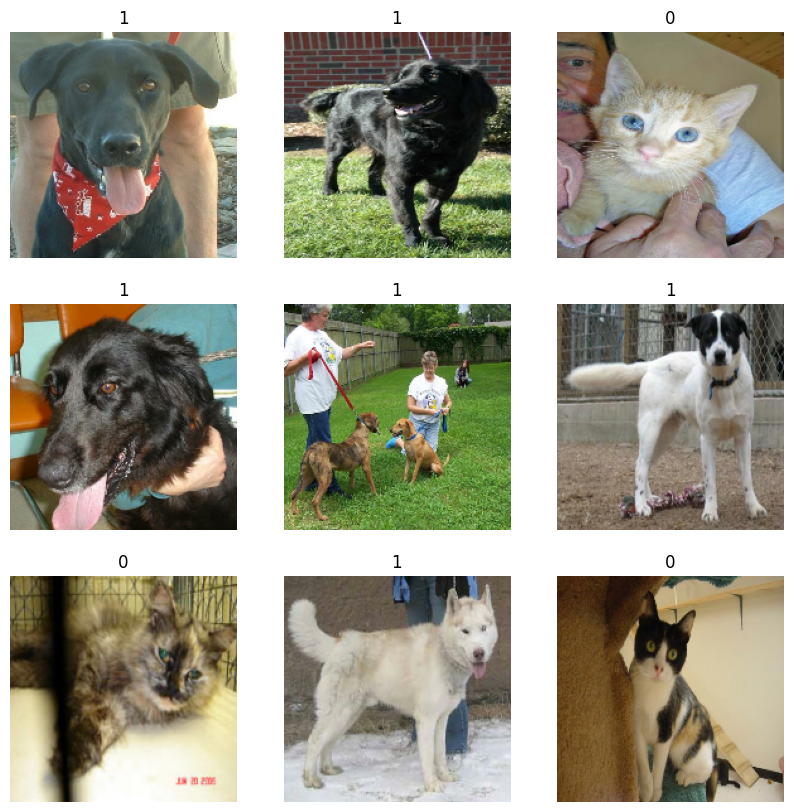

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in  range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

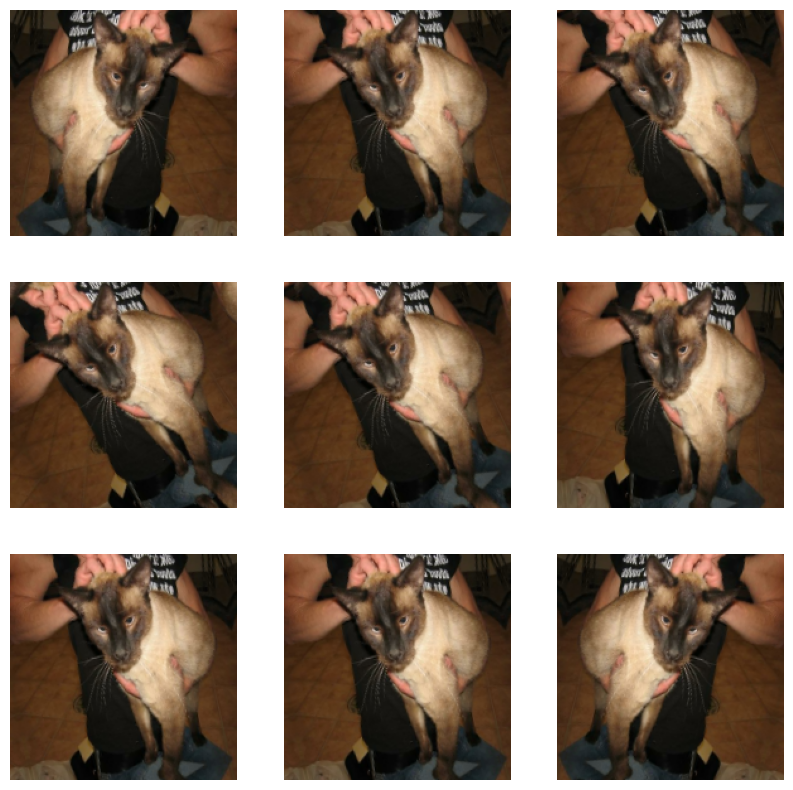

In [8]:
data_augmentation=keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

plt.figure(figsize=(10,10))
for images,_ in train_ds.take(1):
    for i in range(9):
        augmented_images=data_augmentation(images)
        ax=plt.subplot(3,3,i+1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [9]:
train_ds=train_ds.map(
    lambda img,label: (data_augmentation(img),label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
train_ds=train_ds.prefetch(tf.data.AUTOTUNE)
val_ds=val_ds.prefetch(tf.data.AUTOTUNE)

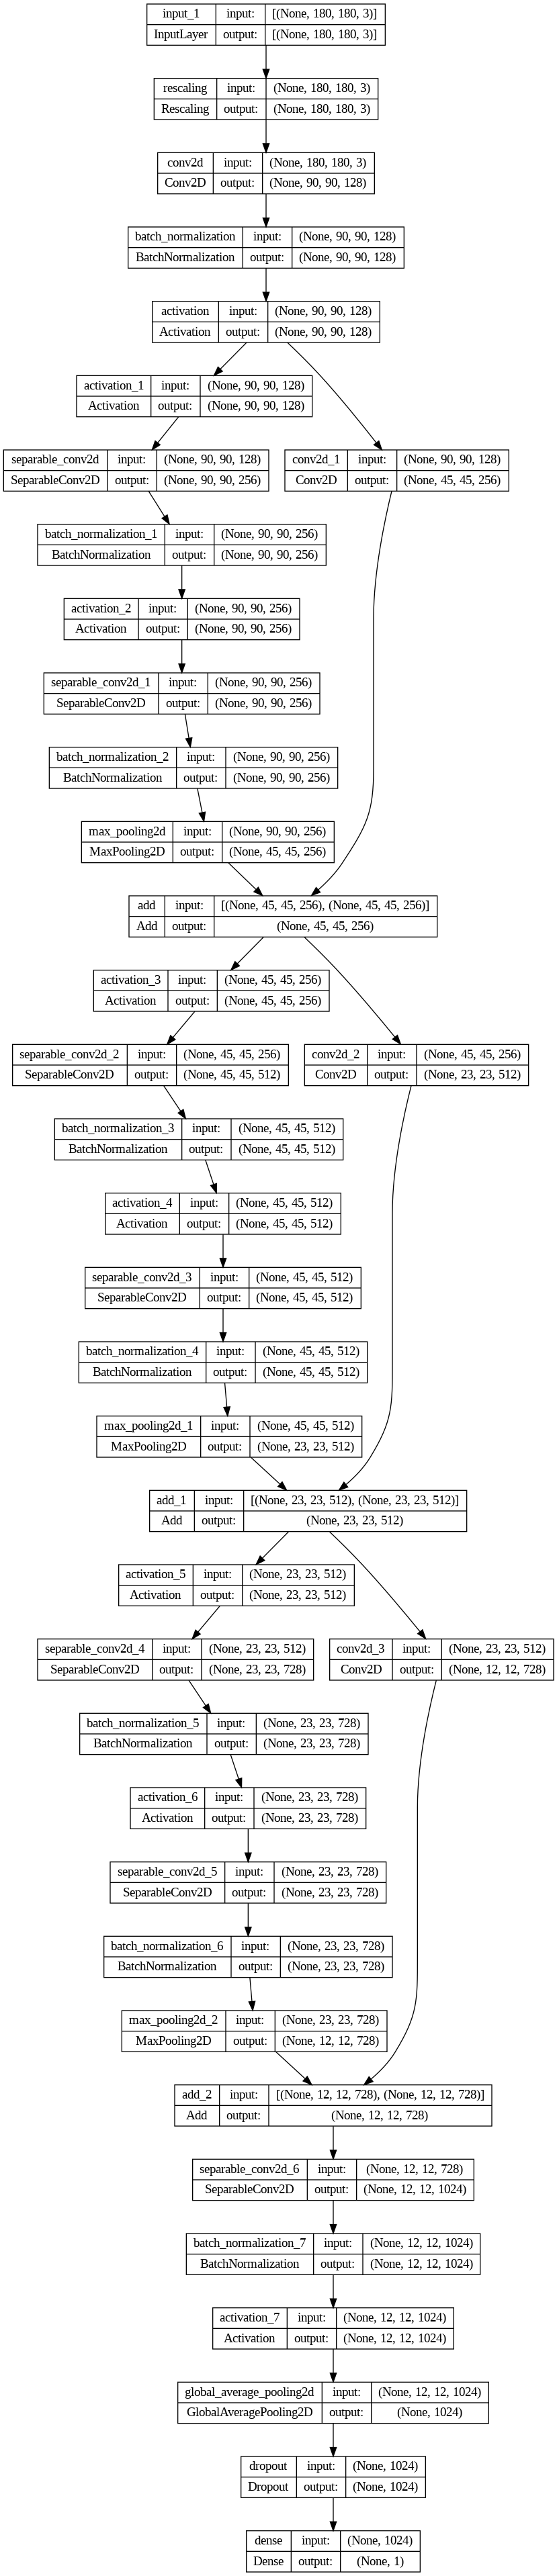

In [10]:
def make_model(input_shape,num_classes):
    inputs=keras.Input(shape=input_shape)

    #Entry block
    x=layers.Rescaling(1/255)(inputs)
    x=layers.Conv2D(128,3,strides=2,padding="same")(x)
    x=layers.BatchNormalization()(x)
    x=layers.Activation("relu")(x)

    previous_block_activation=x

    for size in [256,512,728]:
        x=layers.Activation("relu")(x)
        x=layers.SeparableConv2D(size,3,padding="same")(x)
        x=layers.BatchNormalization()(x)

        x=layers.Activation("relu")(x)
        x=layers.SeparableConv2D(size,3,padding="same")(x)
        x=layers.BatchNormalization()(x)

        x=layers.MaxPooling2D(3,strides=2,padding="same")(x)

        # Project residual
        residual=layers.Conv2D(size,1,strides=2,padding="same")(
            previous_block_activation
        )
        x=layers.add([x,residual])
        previous_block_activation = x

    x=layers.SeparableConv2D(1024,3,padding="same")(x)
    x=layers.BatchNormalization()(x)
    x=layers.Activation("relu")(x)

    x=layers.GlobalAveragePooling2D()(x)
    if num_classes==2:
        activation="sigmoid"
        units=1
    else:
        activation="softmax"
        units=num_classes

    x=layers.Dropout(0.5)(x)
    outputs = layers.Dense(units,activation=activation)(x)
    return keras.Model(inputs,outputs)

model=make_model(input_shape=image_size + (3,),num_classes=2)
keras.utils.plot_model(model,show_shapes=True)

In [11]:
epochs=2
callbacks=[
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/2
147/147 [==============================] - 260s 2s/step - loss: 0.6402 - accuracy: 0.6491 - val_loss: 0.7836 - val_accuracy: 0.4957
Epoch 2/2
147/147 [==============================] - 224s 2s/step - loss: 0.4817 - accuracy: 0.7688 - val_loss: 1.3677 - val_accuracy: 0.4957


1/1 [==============================] - 1s 902ms/step
This image is 92.85% cat and 7.15% dog.


<ipython-input-12-f25b229edee1>:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(predictions[0])


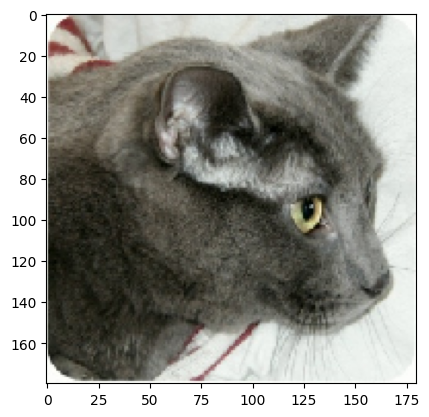

In [12]:
img = keras.utils.load_img(
    "PetImages/Cat/6779.jpg", target_size=image_size
)
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(predictions[0])
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")